In [8]:
! pip install --user requests
! pip install --user Pillow
! pip install --user beautifulsoup4

  Using cached beautifulsoup4-4.6.0-py2-none-any.whl


In [2]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

In [3]:
#posts, images = utils.getData()

In [6]:
print len(posts)
print images.shape
data = pandas.DataFrame(posts)

375
(650, 750, 750, 3)


In [7]:
hasImage = []
for i in range(images.shape[0]):
    if (images[i].mean() == 0.):
        hasImage += [False]
    else:
        hasImage += [True]
print len(hasImage)
images2 = []
images2 = images[hasImage]
print images2.shape, images.shape

650
(375, 750, 750, 3) (650, 750, 750, 3)


In [8]:
#data

In [9]:
if False:
    index = 11

    fig = plt.figure(figsize=[15,15])

    ax1 = fig.add_subplot(221)
    ax1.imshow(images2[index]/255.)

    ax2 = fig.add_subplot(222)
    hist,bins = np.histogram(images2[index]/255.,bins=1000)
    ax2.plot(.5*(bins[1:]+bins[:-1]),hist)

    plt.show()

    print data.iloc[index]

In [2]:
foodposts, foodimages = utils.getData('posts_food_1505318769.json',rawimages=True)
print len(foodposts), foodimages.shape
data = pandas.DataFrame(foodposts)

326 (326, 300, 300, 3)


In [3]:
def getlist(x,args,y):
    list = x['caption'].split(' #')
    return not (args in list[1:])

#data.loc[data.apply(getlist,args=[u'fashion',0],axis=1)]

In [4]:
from scipy.misc import imresize
import features

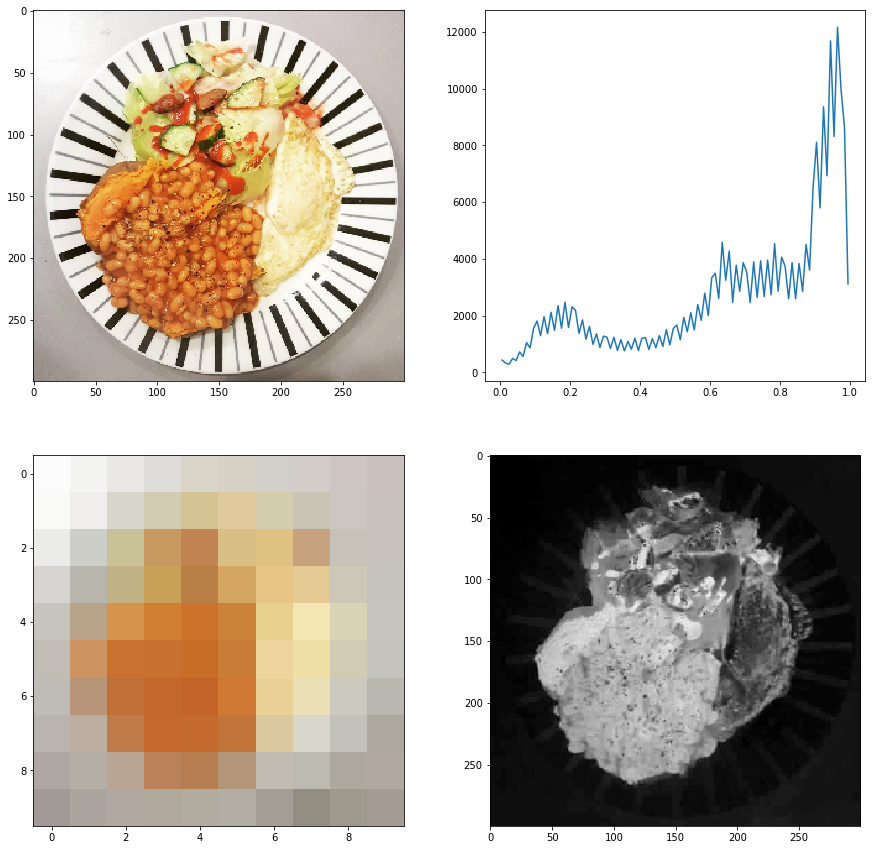

caption      Carbbssss 🙋‍♀️ I'm eating out tonight so this ...
code                                               BY_L581ndZD
comments                                                     2
date                                                1505318753
height                                                    1080
id                                         1603052353213027907
imgurl       https://instagram.fbed1-1.fna.fbcdn.net/t51.28...
likes                                                       24
timestamp                                          1.50535e+09
userid                                                17219868
width                                                     1080
Name: 11, dtype: object


In [5]:
index = 11

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(221)
ax1.imshow(foodimages[index]/255.)

ax2 = fig.add_subplot(222)
hist,bins = np.histogram(foodimages[index]/255.,bins=100)
ax2.plot(.5*(bins[1:]+bins[:-1]),hist)

ax3 = fig.add_subplot(223)
newimage = np.zeros([10,10,3])
for i in range(3):
    newimage[:,:,i] = imresize(foodimages[index,:,:,i],[10,10])
ax3.imshow(newimage/255.)

ax4 = fig.add_subplot(224)
rgb = foodimages[index]
saturation = features.saturation(rgb,options=['xyz','mean'])
saturation = features.colorfulness(rgb,option='rgb')
ax4.imshow(saturation, cmap='gray')

plt.show()

print data.iloc[index]

In [4]:
import utils
import json
import pandas
import features
from scipy.misc import imresize

In [5]:
posts, images = utils.getData('posts_food_1505318769.json',updated=True,rawimages=True)
with open('data/users_food_1505318769.json','r') as infile:
        users = json.load(infile)
#newposts = utils.updateData(posts)
#with open('data/posts2_food_1505318769.json','w') as outfile:
#    json.dump(newposts,outfile)

dfu = pandas.DataFrame(users)
dfp = pandas.DataFrame(posts)

In [6]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S

In [9]:
nbins = 20
satH = np.zeros([len(posts),nbins])
conH = np.zeros([len(posts),nbins])
sat = np.zeros([len(posts)])
contrast = np.zeros([len(posts)])

dims = 5
comp = np.zeros([len(posts),dims**2])

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

MSE: 0.070826
R2S: 0.012823


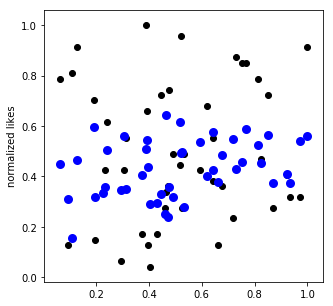

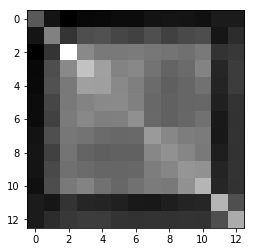

[-0.00283717  0.00466347  0.00959564  0.01133533  0.01161369  0.00768132
  0.0073362   0.00736779  0.00700553  0.00735979  0.00700958  0.0196634
  0.05879643]


In [11]:
likes = dfp['likes'].apply(lambda x: float( ''.join( str(x).split(',') ) ) ).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1

keep = (likes < 50) & (likes > 1)

keep = dfp.apply(getlist,args=[u'fashion',0],axis=1).values & keep

goodposts = dfp.loc[keep]
goodsat = sat[keep]
goodcontrast = conH[keep]
gcomp = comp[keep]

likes = likes[keep]
ntags = ntags[keep]

minsat = np.min(sat)
maxsat = np.max(sat)
mincon = np.min(goodcontrast)
maxcon = np.max(goodcontrast)
minlike = min(likes)
maxlike = max(likes)
#mincomp = min(comp)
#maxcomp = max(comp)
mintags = min(ntags)
maxtags = max(ntags)

goodsat = (goodsat - minsat)/(maxsat-minsat)
goodcontrast = (goodcontrast - mincon)/(maxcon-mincon)
likes = (likes - minlike)/(maxlike - minlike)
#likes = likes - minlike
gcomp = gcomp/255.
ntags = (ntags - np.mean(ntags))/(maxtags - mintags)

#print conH[0,-1]
#conH[:,-1] *= 4
#print conH[0,-1]

nposts = len(goodposts)
#ntrain = int(nposts*.8)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
train = np.logical_not(test)
ntrain = len(np.where(train)[0])

if True:
    data_train = np.zeros([ntrain,(1+2+4+4+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1:3] = goodcontrast[train,-2:]
    data_train[:,3:7] = gcomp[train,:4]
    data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,-1] = ntags[train]

    data_test = np.zeros([(nposts-ntrain),(1+2+4+4+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1:3] = goodcontrast[test,-2:]
    data_test[:,3:7] = gcomp[test,:4]
    data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,-1] = ntags[test]

elif False:
    data_train = np.zeros([ntrain,(20+1)])
    data_train[:,0:20] = goodsat[train,:]
    data_train[:,-1] = goodcontrast[train]

    data_test = np.zeros([(nposts-ntrain),(20+1)])
    data_test[:,0:20] = goodsat[test,:]
    data_test[:,-1] = goodcontrast[test]

elif False:
    data_train = np.zeros([ntrain,(1+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,-1] = goodcontrast[train]

    data_test = np.zeros([(nposts-ntrain),(1+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,-1] = goodcontrast[test]

elif True:
    data_train = np.zeros([ntrain,(1+2)])
    data_train[:,0] = goodsat[train]
    data_train[:,-2:] = goodcontrast[train,-2:]

    data_test = np.zeros([(nposts-ntrain),(1+2)])
    data_test[:,0] = goodsat[test]
    data_test[:,-2:] = goodcontrast[test,-2:]

y_train = likes[train]
y_test = likes[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)

print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)

fig = plt.figure(figsize=[5,5])
feat = -2
plt.scatter(data_test[:,feat], y_test,  color='black')
plt.scatter(data_test[:,feat], y_pred, color='blue', linewidth=3)
#plt.xlabel('normalized contrast')
plt.ylabel('normalized likes')
plt.show()

cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
plt.imshow(cov,cmap='gray')
plt.show()
print cov[-1,:] #, data_test[1,:]

In [4]:
import json
with open('/home/albert/Data/scraper/iceandvice/iceandvice.json','r') as infile:
    scrapedata = json.load(infile)
len(scrapedata)
scrapedata[0]
struct = utils.search_old('cake')

24 results


In [1]:
import utils
data,images = utils.dataFromScraper('iceandvice')

{'code': u'BY_TNJ0AnCO', 'height': 712, 'date': u'1505322581', 'likes': 1405, 'createdtime': u'1505322581', 'id': u'1603084459140345998_469741330', 'imgurl': u'https://instagram.fbed1-1.fna.fbcdn.net/t51.2885-15/sh0.08/e35/p640x640/21480112_1940667256212748_7498698932411695104_n.jpg', 'caption': u"Casual adults aren't afraid of the dark (\U0001f4f7: @lauraleexj). From our newest collab w/ @macaronparlour @lemonrenegade: Renegade Vice Parlour, a new dessert counter for the casual adult. Here's ONYX: jasmine charcoal snow, soju (+21 option), watermelon charcoal sorbetto, raspberry chocolate macaron sprig. Now EXCLUSIVELY at #MadSqEats. #RVP #iceandvice", 'userid': u'469741330', 'comments': 17, 'width': 640}


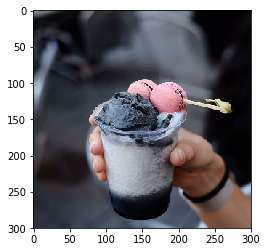

In [3]:
i = 0
print data[i]
plt.imshow(images[i]/255.)
plt.show()